In [351]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# random seed for reproducibility
seed = 123456789
np.random.seed(seed)

raw_data = pd.read_csv("International students Time management data.csv")

#Question 6: You often feel that your life is aimless, with no definite purpose
target_column = '6'
raw_data = raw_data[raw_data[target_column] != 'Neither']
raw_data = raw_data[raw_data[target_column].notna()]
raw_data[target_column] = raw_data[target_column].replace('Strong Agree', 'Agree')
raw_data[target_column] = raw_data[target_column].replace('Strong Disagree', 'Disagree')

In [352]:
impute_and_one_hot = Pipeline([
    ('impute', SimpleImputer(strategy= 'most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

answers = ['Strong Disagree', 'Disagree', 'Neither', 'Agree', 'Strong Agree']
percentages = ['<40%', '40%~49%', '50%~59%', '60%~70%','>70%']

impute_and_ordinal = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[percentages,
                                           ['S4', 'S3', 'S2', 'S1', 'S0'],
                                           ['<18', '18-20', '21-25', '26-30', '31-35', '>36'],
                                           percentages,
                                           answers, answers, answers, answers])),
    ('scaler', StandardScaler())
])

feature_encoding = ColumnTransformer([
    ("impute_and_one_hot", impute_and_one_hot, ['Course']),
    ("impute_and_ordinal", impute_and_ordinal,['Academic', 'Attendance', 'Age', 'English',
                                                '8','12', '14', '15'])
])

pipeline = Pipeline([
    ('features', feature_encoding),
    ('tree', DecisionTreeClassifier(random_state = 1))
])

In [353]:
hyperparam_grid = {
    "tree__max_depth" :[5, 10, 15, 20],
    "tree__max_features":["auto","log2","sqrt", None],
    "tree__max_leaf_nodes":[2, 4, 6, 8, 10],
    "tree__min_samples_split": [5, 8, 11, 14, 17]
}

grid_search = GridSearchCV(pipeline, param_grid=hyperparam_grid, cv=3, n_jobs=-1,return_train_score=True)

In [354]:
X_train, X_test, y_train_raw, y_test_raw = \
  train_test_split(raw_data, raw_data[target_column], test_size=.3, random_state=seed)

y_train = np.squeeze(label_binarize(y_train_raw, classes=['Agree', 'Disagree']))
y_test = np.squeeze(label_binarize(y_test_raw, classes=['Agree', 'Disagree']))

model = grid_search.fit(X_train, y_train)

print(model.best_params_)

{'tree__max_depth': 10, 'tree__max_features': 'auto', 'tree__max_leaf_nodes': 10, 'tree__min_samples_split': 11}


In [355]:
model.score(X_train, y_train)

0.7611940298507462

In [356]:
model.score(X_test, y_test)

0.7931034482758621

In [357]:
confusion_matrix(y_test, model.predict(X_test))

array([[ 4,  3],
       [ 3, 19]], dtype=int64)

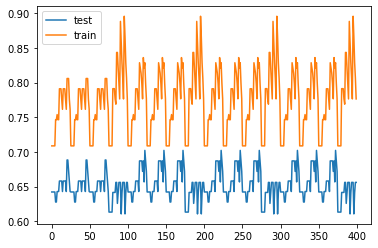

In [358]:
import matplotlib.pyplot as plt

test_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [359]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [360]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

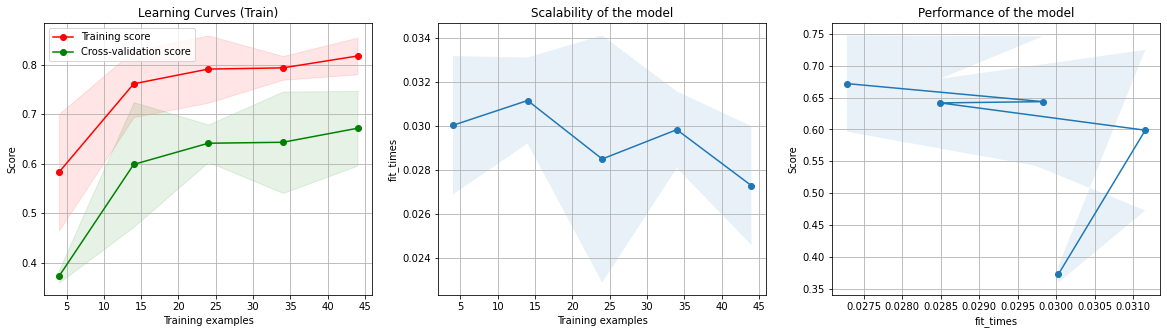

In [361]:
X, y = X_train, y_train
title = "Learning Curves (Train)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = model.best_estimator_
# estimator = DecisionTreeClassifier()
# plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01),
#                     cv=3, n_jobs= -1)

plot_learning_curve(estimator, title, X, y,
                    cv=3, n_jobs=-1)


plt.show()

In [362]:
from sklearn.model_selection import learning_curve
# from sklearn.metrics import make_scorer, roc_curve

# train_sizes = [1, 5, 10, 15, 20, 25, 30, 35]

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model.best_estimator_,
    X=X_train, y=y_train, cv=3,
#     scoring=make_scorer(roc_curve),
)

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[0.75       0.5        0.5       ]
 [0.85714286 0.71428571 0.71428571]
 [0.875      0.79166667 0.70833333]
 [0.76470588 0.82352941 0.79411765]
 [0.86363636 0.77272727 0.81818182]]

 ----------------------------------------------------------------------

Validation scores:

 [[0.39130435 0.36363636 0.36363636]
 [0.47826087 0.54545455 0.77272727]
 [0.65217391 0.59090909 0.68181818]
 [0.52173913 0.63636364 0.77272727]
 [0.65217391 0.59090909 0.77272727]]
